In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks


import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
tf.__version__

'2.2.0'

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

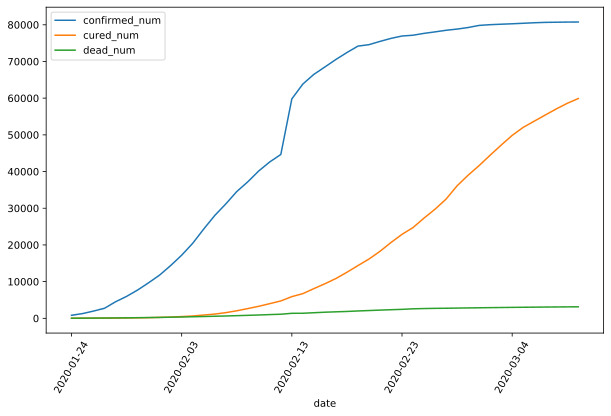

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)

In [3]:
df.head()

,date,confirmed_num,cured_num,dead_num
0,2020-01-24,830.0,34.0,25.0
1,2020-01-25,1287.0,38.0,41.0
2,2020-01-26,1975.0,49.0,56.0
3,2020-01-27,2744.0,51.0,80.0
4,2020-01-28,4515.0,60.0,106.0


In [5]:
df.describe()

,confirmed_num,cured_num,dead_num
count,47.000000,47.000000,47.000000
mean,51783.893617,18676.851064,1609.617021
std,30387.033028,20548.558553,1143.828213
min,830.000000,34.000000,25.000000
25%,22381.000000,762.000000,457.500000
50%,68500.000000,9419.000000,1665.000000
75%,78660.500000,34306.000000,2766.000000
max,80754.000000,59897.000000,3136.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           47 non-null     object 
 1   confirmed_num  47 non-null     float64
 2   cured_num      47 non-null     float64
 3   dead_num       47 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.6+ KB


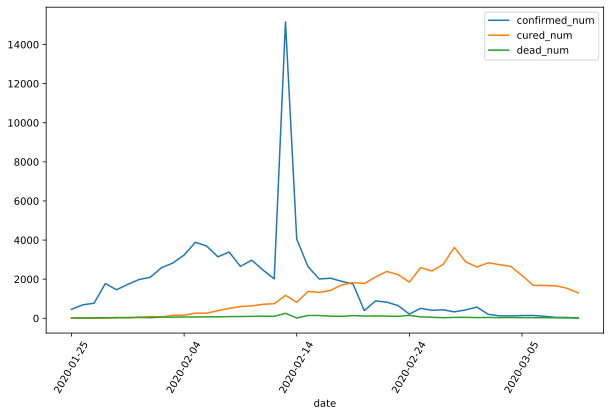

In [7]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna() # 将第一列做基准, 向下相减, 就是看增长率
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [9]:
dfdata.diff(periods=1).head()

,confirmed_num,cured_num,dead_num
date,,,
2020-01-24,NaN,NaN,NaN
2020-01-25,457.0,4.0,16.0
2020-01-26,688.0,11.0,15.0
2020-01-27,769.0,2.0,24.0
2020-01-28,1771.0,9.0,26.0


In [10]:
dfdata.head()

,confirmed_num,cured_num,dead_num
date,,,
2020-01-24,830.0,34.0,25.0
2020-01-25,1287.0,38.0,41.0
2020-01-26,1975.0,49.0,56.0
2020-01-27,2744.0,51.0,80.0
2020-01-28,4515.0,60.0,106.0


In [11]:
dfdiff.head()

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0


In [12]:
WINDOW_SIZE = 8

In [13]:
def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

In [15]:
next(iter(ds_data))

<tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[4.570e+02, 4.000e+00, 1.600e+01],
       [6.880e+02, 1.100e+01, 1.500e+01],
       [7.690e+02, 2.000e+00, 2.400e+01],
       [1.771e+03, 9.000e+00, 2.600e+01],
       [1.459e+03, 4.300e+01, 2.600e+01],
       [1.737e+03, 2.100e+01, 3.800e+01],
       [1.981e+03, 4.700e+01, 4.300e+01],
       [2.099e+03, 8.800e+01, 3.000e+01]], dtype=float32)>

In [18]:
ds_data.batch

<bound method DatasetV2.batch of <FlatMapDataset shapes: (8, 3), types: tf.float32>>

In [19]:
ds_label.batch

<bound method DatasetV2.batch of <TensorSliceDataset shapes: (3,), types: tf.float32>>

In [27]:
dfdiff.head().values.shape

(5, 3)

In [28]:
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config

In [29]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

In [30]:
[x_input]

[<tf.Tensor 'input_1:0' shape=(None, None, 3) dtype=float32>]

In [31]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [32]:
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = os.path.join('models', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
from pathlib import Path
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = str(Path('./models/autograph/' + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

Epoch 1/500
1/1 [==============================] - 0s 31ms/step - loss: 3.2073 - lr: 0.0100
Epoch 2/500
1/1 [==============================] - 0s 8ms/step - loss: 2.9442 - lr: 0.0100
Epoch 3/500
1/1 [==============================] - 0s 7ms/step - loss: 2.6731 - lr: 0.0100
Epoch 4/500
1/1 [==============================] - 0s 7ms/step - loss: 2.3851 - lr: 0.0100
Epoch 5/500
1/1 [==============================] - 0s 9ms/step - loss: 2.0788 - lr: 0.0100
Epoch 6/500
1/1 [==============================] - 0s 7ms/step - loss: 1.7608 - lr: 0.0100
Epoch 7/500
1/1 [==============================] - 0s 7ms/step - loss: 1.4441 - lr: 0.0100
Epoch 8/500
1/1 [==============================] - 0s 9ms/step - loss: 1.1458 - lr: 0.0100
Epoch 9/500
1/1 [==============================] - 0s 9ms/step - loss: 0.8884 - lr: 0.0100
Epoch 10/500
1/1 [==============================] - 0s 7ms/step - loss: 0.6922 - lr: 0.0100
Epoch 11/500
1/1 [==============================] - 0s 7ms/step - loss: 0.5701 - lr: 0.0

In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

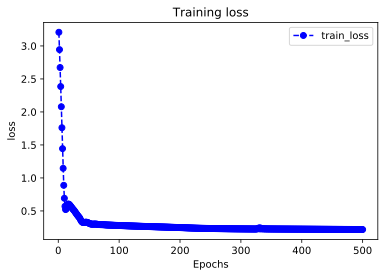

In [34]:
plot_metric(history,"loss")

In [35]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [36]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [37]:
dfresult.query("confirmed_num==0").head()

,confirmed_num,cured_num,dead_num
50,0.0,704.0,1.0
51,0.0,622.0,0.0
52,0.0,549.0,0.0
53,0.0,485.0,0.0
54,0.0,428.0,0.0


In [38]:
dfresult.query("cured_num==0").head()

,confirmed_num,cured_num,dead_num
90,0.0,0.0,0.0
91,0.0,0.0,0.0
92,0.0,0.0,0.0
93,0.0,0.0,0.0
94,0.0,0.0,0.0


In [39]:
dfresult.query("dead_num==0").head()

,confirmed_num,cured_num,dead_num
51,0.0,622.0,0.0
52,0.0,549.0,0.0
53,0.0,485.0,0.0
54,0.0,428.0,0.0
55,0.0,378.0,0.0


In [40]:
model.save('./models/tf_model_savedmodel_convi', save_format="tf")
print('export saved model.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/tf_model_savedmodel_convi/assets
export saved model.


In [44]:
dirt = './models/tf_model_savedmodel_convi'

In [45]:
model_loaded = tf.keras.models.load_model(dirt, compile=False)

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

array([[1.28776758e+03, 9.29486160e+01, 2.40158367e+00],
       [1.58838977e+03, 7.28801651e+01, 4.88322020e+00],
       [1.73317920e+03, 1.55266434e+02, 4.56300926e+00],
       [1.98349329e+03, 1.65828781e+02, 5.12337875e+00],
       [2.38411841e+03, 2.74620911e+02, 5.20343161e+00],
       [2.26632349e+03, 2.75677124e+02, 5.84385395e+00],
       [1.92827698e+03, 4.08762665e+02, 5.84385395e+00],
       [2.07674756e+03, 5.38679443e+02, 6.88454008e+00],
       [1.62704126e+03, 6.32684326e+02, 7.12469864e+00],
       [1.82397949e+03, 6.67540039e+02, 7.76512098e+00],
       [1.51354102e+03, 7.55207458e+02, 8.64571476e+00],
       [1.23623254e+03, 7.85838379e+02, 7.76531744e+00],
       [9.29534961e+03, 1.23685071e+03, 2.03384056e+01],
       [2.48285034e+03, 8.57663940e+02, 1.04284120e+00],
       [1.62005139e+03, 1.45023987e+03, 1.16292696e+01],
       [1.29610950e+03, 1.43199524e+03, 7.47925491e+01],
       [1.21939966e+03, 1.57714771e+03, 9.90167236e+01],
       [8.65945618e+02, 1.88631